# Define functions we will use

The linear activation function is used since this is a regression task. Mean squared error is used as the loss function since it is well suited for regression.

In [105]:
import tensorflow as tf
import numpy as np

def mse(y, y_true):
    return tf.square(y - y_true)

# Define main training and evaluation function

Takes in a mini batch and layers and returns updated layers

In [106]:
def train(batch, w1, b1, out_w, out_b, eta):
    dw1 = tf.zeros(w1.shape)
    db1 = tf.zeros(b1.shape)

    out_dw = tf.zeros(out_w.shape)
    out_db = tf.zeros(out_b.shape)  

    for x, y_true in batch:
        with tf.GradientTape(persistent=True) as tape:
            # forward propagation
            tape.watch([w1, b1, out_w, out_b])
            y = evaluate(x, w1, b1, out_w, out_b)
            loss = mse(y, y_true)

        # back propagation
        out_dw += tape.gradient(loss, out_w)
        out_db += tape.gradient(loss, out_b)

        dw1 += tape.gradient(loss, w1)
        db1 += tape.gradient(loss, b1)

        del tape

    # adjust weights and bias with the mini batch results
    w1 = w1 - eta * dw1 / len(batch)
    b1 = b1 - eta * db1 / len(batch)
        
    out_w = out_w - eta * out_dw / len(batch)
    out_b = out_b - eta * out_db / len(batch)

    return w1, b1, out_w, out_b

def evaluate(x, w1, b1, out_w, out_b):
    x = tf.reshape(x, (1 ,x.shape[0]))
    z1 = tf.add(tf.matmul(x, w1), b1)
    y = tf.add(tf.matmul(z1, out_w), out_b)

    return y

# Load data, separate into training, validation, and testing sets and perform preprocessing

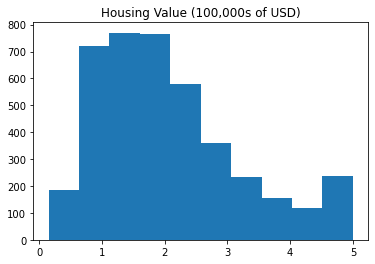

In [107]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

data = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

plt.title("Housing Value (100,000s of USD)")
plt.hist(y_test)
plt.show()

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_scale = StandardScaler().fit(X_train)
y_scale = StandardScaler().fit(y_train)

X_train = tf.convert_to_tensor(X_scale.transform(X_train), np.float32)
y_train = tf.convert_to_tensor(y_scale.transform(y_train), np.float32)
X_test = tf.convert_to_tensor(X_scale.transform(X_test), np.float32)
y_test = tf.convert_to_tensor(y_scale.transform(y_test), np.float32)

training = tf.data.Dataset.from_tensor_slices((X_train, y_train))
testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 20
validation_size = int(0.1 * len(training))

validation = training.take(validation_size)
training = training.skip(validation_size).batch(batch_size)

# Define hyperparameters and begin training

In [108]:
layer1_size = 100
epochs = 5
eta = 0.01

w1 = tf.random.uniform((X_train.shape[1], layer1_size), minval=0.0001, maxval=0.001)
b1 = tf.random.uniform((1, layer1_size), minval=0.0001, maxval=0.001)

out_w = tf.random.uniform((layer1_size, 1), minval=0.0001, maxval=0.001)
out_b = tf.random.uniform((1, 1), minval=0.0001, maxval=0.001)

for i in range(epochs):
    for batch in training:
        batch = tf.data.Dataset.from_tensor_slices(batch)
        w1, b1, out_w, out_b = train(batch, w1, b1, out_w, out_b, eta)

    error = 0
    for x, y in validation:
        error += mse(evaluate(x, w1, b1, out_w, out_b), y)

    print(f"Epoch {i + 1} - Total Error: {float(error)}")

Epoch 1 - Total Error: 742.1175537109375
Epoch 2 - Total Error: 693.30712890625
Epoch 3 - Total Error: 676.4423217773438
Epoch 4 - Total Error: 671.6309814453125
Epoch 5 - Total Error: 670.22705078125


# Evaluate testing set

In [109]:
from sklearn.metrics import r2_score

y_pred = []
y_true = []
error = 0

for x, y in testing:
    prediction = float(y_scale.inverse_transform(np.array(evaluate(x, w1, b1, out_w, out_b)).reshape(-1, 1)))
    truth = float(y_scale.inverse_transform(np.array(y).reshape(-1, 1)))

    error += mse(prediction, truth)

    y_pred.append(prediction)
    y_true.append(truth)

print(f"Final error: {error}")
print(f"R^2 score: {r2_score(y_true, y_pred)}")


Final error: 2177.672119140625
R^2 score: 0.6063026371989404
